In [119]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Loading Dataset

In [120]:
gender = pd.read_csv("../data/gender_anonymized.csv")

#row is the source, column is the target(receiver)
message_adjmatrix = pd.read_csv("../data/slack_direct_matrix_anonymized.csv", index_col=0)
members_c_channel = pd.read_csv("../data/slack_members_count_channel_anonymized.csv")
members_c_group = pd.read_csv("../data/slack_members_count_group_anonymized.csv")
#members_c_group.head()

#message_adjmatrix.head()
#message_adjmatrix.shape

# convert col into int
message_adjmatrix.columns = message_adjmatrix.columns.astype(int)

In [121]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

check_symmetric(message_adjmatrix.to_numpy())
#meaning this should be a directed graph!

False

In [122]:
#this is 900209 (row index = 26) -> 891708 (col name)
#this value can be used for validating successful graph creation!
print("900209 sent 891708:", message_adjmatrix.loc[message_adjmatrix.index[26], 891708], "messages") # 900209 sent 891708 -> 13 
print("891708 sent 900209:", message_adjmatrix.loc[message_adjmatrix.index[5], 900209], "messages") # 891708 sent 900209 ->  26

900209 sent 891708: 13.0 messages
891708 sent 900209: 26.0 messages


## Graph Initialization & Attributes

In [123]:
#https://notebook.community/rtidatascience/connected-nx-tutorial/notebooks/2.%20Creating%20Graphs

# Creating a directed graph! 
GAAdj = nx.from_numpy_array(message_adjmatrix.values, create_using=nx.DiGraph())

In [124]:
label_mapping = dict(zip(GAAdj.nodes(), message_adjmatrix.columns))
GAAdj = nx.relabel_nodes(GAAdj, label_mapping)

#checking directed
#nx.is_directed(GAAdj)

print("900209 sent 891708:", GAAdj[900209][891708])
print("891708 sent 900209:", GAAdj[891708][900209])

900209 sent 891708: {'weight': 13.0}
891708 sent 900209: {'weight': 26.0}


In [125]:
#gender.loc[gender['fake_id'] == 719556]['gender'][0]
gender = gender.astype({"fake_id": int})
gender_dict = dict(zip((gender.fake_id), gender.gender))

In [126]:
#set vertex attribute: gender
nx.set_node_attributes(GAAdj, gender_dict, name="gender")

In [127]:
#checking gender of each node
print("gender for 719556:", GAAdj.nodes[719556]["gender"])
print("gender for 230271:", GAAdj.nodes[230271]["gender"])

gender for 719556: M
gender for 230271: F


## Basic Statistic & Measures

In [128]:
pos = nx.random_layout(GAAdj)
fig = plt.figure(1, figsize=(20, 10), dpi=60)
#nx.draw(GAAdj,with_labels=True, cmap=plt.cm.Set1, font_size=15, node_size=1000, pos=pos)

<Figure size 1200x600 with 0 Axes>

In [129]:
print("nodes number: ", GAAdj.number_of_nodes())
print("edges number: ", GAAdj.number_of_edges())

nodes number:  983
edges number:  17377


Text(0.5, 1.0, 'Eigenvector')

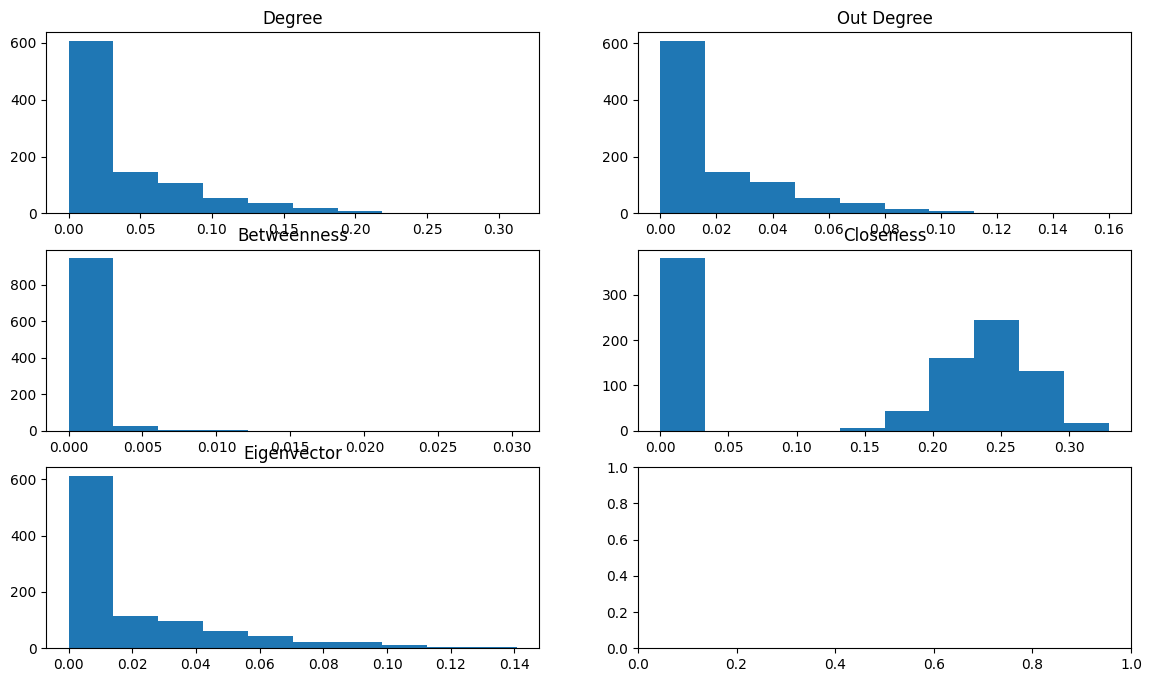

In [130]:
fig, axs = plt.subplots(3, 2, figsize = (14, 8))

axs[0, 0].hist(nx.centrality.degree_centrality(GAAdj).values())
axs[0, 0].set_title('Degree')

axs[0, 1].hist(nx.centrality.out_degree_centrality(GAAdj).values())
axs[0, 1].set_title('Out Degree')

axs[1, 0].hist(nx.centrality.betweenness_centrality(GAAdj).values())
axs[1, 0].set_title('Betweenness')

axs[1, 1].hist(nx.centrality.closeness_centrality(GAAdj).values())
axs[1, 1].set_title('Closeness')

#Eigenvector is not implemente for multi-graph type -> I used DiGraph instead 
# DiGraph => Directed Network        
# MultiDiGraph => Multiple types of edges  (overlay both undirected & directed together)
axs[2, 0].hist(nx.centrality.eigenvector_centrality(GAAdj).values())
axs[2, 0].set_title('Eigenvector')

#TODO: examine closenss centrality: applies to the fully conencted network; but this one is a directed with different components,
#calculations will be off. Remove the closness centrality part. 

In [131]:
#Cluster Average The following is not implemented for directed Graph
#print("Clustering Average:", nx.cluster.average_clustering(GAAdj))

# returns clustering coefficient for each node:
cluster_coeff =nx.clustering(GAAdj)

filtered_vals = [v for _, v in cluster_coeff.items() if v != 0]
average = sum(filtered_vals) / len(filtered_vals)
print("Clustering Average for all nodes with cluster value is:", average, "(does not include nodes with clustering coeffcient of 0)")
print("Clustering Average for all nodes with cluster value is:", sum(filtered_vals) / GAAdj.number_of_nodes())


# if and only if every vertex in the graph is reachable from every other vertex.
print("Graph is strongly connected:", nx.is_strongly_connected(GAAdj))

#if the graph is connected when the direction of the edge between nodes is ignored.
#thinking of undirected network, and see if everyone is reachable in nodes.
print("Graph is weakly connected:", nx.is_weakly_connected(GAAdj))

#Number of strongly & weakly connected components
#Directed ties or undirected ties => will give you information about the communication silos in the organization 
#Each component can think of an informal group
print("Number of strongly connected components: ", nx.number_strongly_connected_components(GAAdj))
print("Number of weakly connected components: ", nx.number_weakly_connected_components(GAAdj))

#Size of  strongly connected components
largest_strong = max(nx.strongly_connected_components(GAAdj), key=len)
smallest_strong = min(nx.strongly_connected_components(GAAdj), key=len)
print("Size of largest strongly connected components:", len(largest_strong))
print("Size of smallest weakly connected components:", len(smallest_strong))

#Size of weakly connected components
largest_weak = max(nx.weakly_connected_components(GAAdj), key=len)
smallest_weak = min(nx.weakly_connected_components(GAAdj), key=len)
print("Size of largest weakly connected components:", len(largest_weak))
print("Size of smallest weakly connected components:", len(smallest_weak))

#TODO: histogram of len of connected components => see the average & the distribution 
#str_cc = nx.strongly_connected_components(GAAdj)
#      returns a generator object 
#       print(list(str_cc))

Clustering Average for all nodes with cluster value is: 0.408299605180222 (does not include nodes with clustering coeffcient of 0)
Clustering Average for all nodes with cluster value is: 0.22969448795998246
Graph is strongly connected: False
Graph is weakly connected: False
Number of strongly connected components:  408
Number of weakly connected components:  381
Size of largest strongly connected components: 576
Size of smallest weakly connected components: 1
Size of largest weakly connected components: 603
Size of smallest weakly connected components: 1


## Number of ties between people of the same sex
Gender Homopholy

In [132]:
node_w_gender = 0
node_no_gender = 0

no_gender_list = []

for node in GAAdj.nodes():
   try:
      if (GAAdj.nodes[node]['gender'] == 'F' or GAAdj.nodes[node]['gender'] == 'M'):
         node_w_gender += 1
   except:
      no_gender_list.append(node)
      node_no_gender += 1


print("node with gender attribute:", node_w_gender)
print("node without gender attribute:", node_no_gender)

#double checking if all node in the no_gender_list is not in the gender_anonymized.csv
#gender.head()
#gender['fake_id'].isin(no_gender_list).sum() == returns 0

node with gender attribute: 690
node without gender attribute: 293


In [133]:
samesex_ties = 0
diffsex_ties = 0
label_edges = 0
not_labeled_edges = 0

for u,v in GAAdj.edges():
    #Note: There are some node without gender attribute, we ignore them in this scenari
    try: 
      if (GAAdj.nodes[u]['gender'] == GAAdj.nodes[v]['gender']):
        samesex_ties += 1
      elif (GAAdj.nodes[u]['gender'] != GAAdj.nodes[v]['gender']):
        diffsex_ties += 1

      label_edges += 1
    except:
       #if one of node of the edge does not have gender attribute
       not_labeled_edges += 1
       pass

print("Number of Ties between Same Sex: ", samesex_ties)
print("Number of Ties between Different Sex:", diffsex_ties)
print("Number of Ties without Gender Attribute: ", not_labeled_edges)
    
#print((both_labeled_edges + not_labeled_edges) == GAAdj.number_of_edges())
print("Percentage of Reaching out to Same Gender, excluding non-gendered nodes:", samesex_ties / label_edges)
print("Percentage of Reaching out to Different Gender, excluding non-gendered nodes:", diffsex_ties / label_edges)

Number of Ties between Same Sex:  7192
Number of Ties between Different Sex: 5562
Number of Ties without Gender Attribute:  4623
Percentage of Reaching out to Same Gender, excluding non-gendered nodes: 0.5639015210914223
Percentage of Reaching out to Different Gender, excluding non-gendered nodes: 0.4360984789085777


In [134]:
#average weight in all ties
total_weight = 0
same_sex_total_w = 0
different_sex_total_w = 0

for u,v in GAAdj.edges():
    weight = GAAdj.get_edge_data(u, v, default=None)
    total_weight += weight['weight']
    try:
        if (GAAdj.nodes[u]['gender'] == GAAdj.nodes[v]['gender']):
            same_sex_total_w += weight['weight']
        elif (GAAdj.nodes[u]['gender'] != GAAdj.nodes[v]['gender']):
            different_sex_total_w += weight['weight']
    except:
        pass


print("total_weight:", total_weight)
print("average total_weight:", total_weight/GAAdj.number_of_edges())

#average weight in same gender ties
print("average same sex weight:", same_sex_total_w/samesex_ties)

#average weight in different gender ties
print("average different sex weight:", different_sex_total_w/samesex_ties)

total_weight: 742242.0
average total_weight: 42.71404730390746
average same sex weight: 46.09705228031146
average different sex weight: 32.29769187986652


### Data Formatting

In [135]:
from rpy2.robjects import NA_Real
import pyergm
from pyergm import rpy_interface as rpyInterface
from pyergm.network_statistics import NetworkStats
from pyergm.ergm import pyERGM, ModelDiagnostics
from pyergm.simulator import Simulator
from pyergm.data_transformer import DataTransformer

In [136]:
rpackages = ['statnet', 'ergm','texreg', 'base', 'grDevices'] # removing igraph because it causes issues with ergm native functions
renv = rpyInterface.intializeRenv(mirror=1, r_packages= rpackages)
installed_packages = renv.setup_renv()

Installing R packages...
Importing package: statnet
Importing package: ergm
Importing package: texreg
Importing package: base
Importing package: grDevices


In [137]:
def edgelist(df):
    a = df.values
    c = df.columns
    n = len(c)
    
    c_ar = np.array(c)
    out = np.empty((n, n, 2), dtype=c_ar.dtype)
    
    out[...,0] = c_ar[:,None]
    out[...,1] = c_ar
    
    mask = ~np.eye(n,dtype=bool)
    df_out = pd.DataFrame(out[mask], columns=[['Sender','Receiver']])
    df_out['Weight'] = a[mask]
    return df_out

message_edgelist = edgelist(message_adjmatrix)
#len(np.unique(message_edgelist.Receiver))
#message_edgelist

### Re-indexing node ID to from 0 to 983

In [140]:
message_edge = pd.read_csv("data/slack_message_edgelist.csv")

sender_arr = message_edge.Sender.unique()
id_map = {}

for i, sender in enumerate(sender_arr):
    #print(sender)
    id_map[sender] = i

#print(id_map)
message_edge["Sender"] = message_edge["Sender"].map(id_map)
message_edge["Receiver"] = message_edge["Receiver"].map(id_map)
#message_edge.head()

# message_edge.to_csv("/Users/juliachu/Dropbox/Northwestern/2022-2023/SONIC/Sonic_ESM/slack_edgelist_adjustedid.csv")

#### Re-indexing Gender csv from 0 to 983 to previously adjusted node_id
- get dummies but fill in NaN values

In [188]:
gender_realid = gender.copy()

gender_realid["real_id"] = gender_realid["fake_id"].map(id_map).fillna(100000)
gender_realid["real_id"] = gender_realid["real_id"].apply(lambda x: int(x))
gender_realid["real_id"] = gender_realid["real_id"].apply(lambda x: np.nan if x > 1000 else int(x))
#gender_df.to_csv("gender_anonymized1.csv")
gender_realid['real_id'] = gender_realid['real_id'].astype('Int64')


gender_realid_adj = gender_realid.copy().sort_values("real_id")
gender_realid_adj = gender_realid_adj.dropna(axis=0, subset=['real_id'])
gender_realid_adj.head()

for i in range(0, 984):
    if (not(i in gender_realid_adj['real_id'].values)):
        new_row = pd.Series({'fake_id':np.NaN, 'gender':np.NaN, 'real_id':i})
        new_row = new_row.to_frame().T
        gender_realid_adj = pd.concat([gender_realid_adj, new_row], ignore_index = True, axis=0)

gender_realid_adj = gender_realid_adj.copy().sort_values("real_id")
gender_realid_adj['real_id'] = gender_realid_adj['real_id'].astype('Int64')

#display(gender_realid_adj.head())
gender_adj_dum = pd.get_dummies(gender_realid_adj, dummy_na=True)
gender_adj_dum.loc[gender_adj_dum.gender_nan == 1, ["gender_F", "gender_M"]] = np.nan
del gender_adj_dum["gender_nan"]
gender_adj_dum.head()

female_nodes = gender_adj_dum.copy()
del female_nodes["fake_id"]
del female_nodes["real_id"]
del female_nodes["gender_M"]
female_nodes['gender_F'] = female_nodes['gender_F'].astype('Int64')
female_nodes = female_nodes.reset_index()
female_nodes = female_nodes.drop(columns=['index'])
display(female_nodes)

,gender_F
0,0
1,<NA>
2,1
3,0
4,<NA>
...,...
979,1
980,1
981,0
982,1


In [189]:
#female_nodes.to_csv("/Users/juliachu/Dropbox/Northwestern/2022-2023/SONIC/Sonic_ESM/female_nodes.csv")

In [ ]:
#gender_realid.to_csv("/Users/juliachu/Dropbox/Northwestern/2022-2023/SONIC/Sonic_ESM/gender_re_id.csv")

In [ ]:
dt = DataTransformer(renv)
cov_matrix = dt.cov_matrix(message_edge, 'Sender',' Receiver', 983, 983, NA_Real)

# The following code took 15 minutes and is still not ending the run
# Fill matrix with values
# for index, row in message_edge.iterrows():
#     s_idx = int(row['Sender'])
#     r_idx = int(row['Receiver'])
#     cov_matrix.rx[renv.load_robject('cbind')(s_idx,r_idx)] = float(row['Weight'])

Generating covariance matrix for: None
Importing package: base
No covariance column was passed. Returning a matrix with populated values of NA_real_


### Exponential Random Graph Models ERGMs

Intuitioin:
- Find interdependencies between links (if ij's probability depend on presence of jk & ki) (triangles)

In [ ]:
################################
## ERGM Model 1
################################
# The following commands do model estimation for ERGMs.

# formula = "messages ~ edges + mutual"
# vars = {"advice": message_adjmatrix.values}


# # Model definition and parameters
# ergm = pyERGM(installed_packages['ergm'], formula, vars, constraints="~bd(maxout=5)") # This constraint enforces the maximum outdegree is 5
# params = dict({"formula":ergm.formula, "constraints":ergm.constraints}) # make sure to include = for parameters that require = vs parameters that can be upacked such as formula
# model1 = ergm.fit_model(params)
# summary_model1 = ergm.summary(model1)
# print(summary_model1)

NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'numpy.ndarray'>'

In [ ]:
# Homopholy 

#TODO: Json
# Number of ties between people working in the same department/team/channel/group  

# Number of ties between different combinations of leaders(1) and non-leaders(0) #the managerial data 

# Total messages sent: sum of (messages sent from sender to receiver)/100 for all Advice ties 


#Statistical Test:
#Exponential Random Graph Models (ERGMs)

#Regression: 
# assumption, node attributes are independent 
# ties in the network are interdependent to each other;      
  #ie if i have tie with Jasmine, I also have tie with Carli => it's more likely for Jasmine & Carli also has tie (friends' friend) = closure
#ties in the network are not independent of each other  

#that's why we use Exponential Random Graph Models (ERGMs)
#number of tri to compare, if possiblity of ties are higher or lower than the random chance. 